<a href="https://colab.research.google.com/github/UserDs/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_Trip_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Taxi trip time Prediction : Predicting total ride duration of taxi trips in New York City</u></b>

## <b> Problem Description </b>

### Your task is to build a model that predicts the total ride duration of taxi trips in New York City. Your primary dataset is one released by the NYC Taxi and Limousine Commission, which includes pickup time, geo-coordinates, number of passengers, and several other variables.

## <b> Data Description </b>

### The dataset is based on the 2016 NYC Yellow Cab trip record data made available in Big Query on Google Cloud Platform. The data was originally published by the NYC Taxi and Limousine Commission (TLC). The data was sampled and cleaned for the purposes of this project. Based on individual trip attributes, you should predict the duration of each trip in the test set.

### <b>NYC Taxi Data.csv</b> - the training set (contains 1458644 trip records)


### Data fields
* #### id - a unique identifier for each trip
* #### vendor_id - a code indicating the provider associated with the trip record
* #### pickup_datetime - date and time when the meter was engaged
* #### dropoff_datetime - date and time when the meter was disengaged
* #### passenger_count - the number of passengers in the vehicle (driver entered value)
* #### pickup_longitude - the longitude where the meter was engaged
* #### pickup_latitude - the latitude where the meter was engaged
* #### dropoff_longitude - the longitude where the meter was disengaged
* #### dropoff_latitude - the latitude where the meter was disengaged
* #### store_and_fwd_flag - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - Y=store and forward; N=not a store and forward trip
* #### trip_duration - duration of the trip in seconds

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Importing the libraries
import numpy as np
import pandas as pd
from numpy import math
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings('ignore')

# modeling utilities
from scipy.stats import zscore
from sklearn import metrics
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict, train_test_split

In [5]:
df = pd.read_csv("/content/drive/MyDrive/AlmaBetter/Capstone Projects/NYC Taxi Data.csv", parse_dates=['pickup_datetime'])

# Data Inspection

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  object        
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(3)
memory usage: 122.4+ MB


In [7]:
df.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


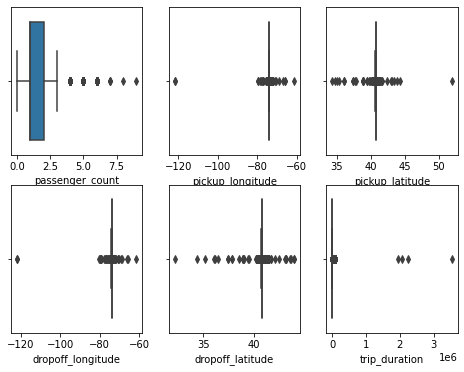

In [8]:
# box plots for outlier detection

plt.figure(figsize = (8, 6))
plt.subplot(2,3,1)
sns.boxplot(x=df.passenger_count)
plt.subplot(2,3,2)
sns.boxplot(x=df.pickup_longitude)
plt.subplot(2,3,3)
sns.boxplot(x=df.pickup_latitude)
plt.subplot(2,3,4)
sns.boxplot(x=df.dropoff_longitude)
plt.subplot(2,3,5)
sns.boxplot(x=df.dropoff_latitude)
plt.subplot(2,3,6)
sns.boxplot(x=df.trip_duration)
plt.show()

# Feature Engineering

In [ ]:
# Not taking 'year' as feature because all trips are from year 2016 only

df['month'] = df.pickup_datetime.apply(lambda t: t.month)
df['weekday'] = df.pickup_datetime.apply(lambda t: t.weekday())
df['weekend'] = df['weekday'].apply(lambda t: 1 if t in [5,6] else 0)
df['hour'] = df.pickup_datetime.apply(lambda t: t.hour) 
# peak_hours
df['peak_hours'] = df['hour'].apply(lambda x: 1 if x in [18,19,20] else 0)

# abs of delta of longitude and latitude pickup-dropoff
df['delta_longitude'] = abs(df.pickup_longitude - df.dropoff_longitude)
df['delta_latitude'] = abs(df.pickup_latitude - df.dropoff_latitude)

In [ ]:
# Function to find direction in degrees (Source: https://gist.github.com/jeromer/2005586)
def get_direction(lat1, lon1, lat2, lon2):
  lon1=lon1.to_numpy()
  lat1=lat1.to_numpy()
  lon2=lon2.to_numpy()
  lat2=lat2.to_numpy()
  diff_lon = np.deg2rad(lon2-lon1)
  x = np.sin(diff_lon) * np.cos(lat2)
  y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(diff_lon))
  initial_bearing = np.arctan2(x, y)

  # Now we have the initial bearing but math.atan2 return values
  # from -180° to + 180°.
  direction = np.degrees (initial_bearing)
  # Now we have the initial bearing but math.atan2 return values
  # from -180° to + 180° which is not what we want for a compass bearing
  # The solution is to normalize the initial bearing as shown below
  initial_bearing = np.degrees (initial_bearing)
  direction = (initial_bearing + 360) % 360
  return direction


# Haversine Formula, distance calculation (between pick-up and drop-off coordinates) 
#(Source: https://www.igismap.com/haversine-formula-calculate-geographic-distance-earth/)
def haversine(lat1, lon1, lat2, lon2):
  # convert decimal degrees to radians 
  lon1=np.deg2rad(lon1.to_numpy())
  lat1=np.deg2rad(lat1.to_numpy())
  lon2=np.deg2rad(lon2.to_numpy())
  lat2=np.deg2rad(lat2.to_numpy())
  # haversine formula 
  dlon = lon2 - lon1 
  dlat = lat2 - lat1 
  a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
  c = 2 * np.arcsin(np.sqrt(a)) 
  r = 6372.8 # Radius of earth in kilometers. Use 3956 for miles
  return np.around(c * r, decimals=2)

In [ ]:
# Create columns 'direction', 'distance_km'
df['direction'] = get_direction(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])

df['distance_km'] = haversine(df['pickup_latitude'], df['pickup_longitude'], \
                                      df['dropoff_latitude'], df['dropoff_longitude'])

In [ ]:
print('Old size: %d' % len(df))

# remove NULL values
df= df.dropna(how = 'any', axis = 'rows')

# removing outliers

df = df[(df['passenger_count']>0) & (df['passenger_count']<=6)]
df = df[df['distance_km']!=0]

df = df[(df['pickup_longitude']<-65) & (-85<df['pickup_longitude'])]
df = df[(30<df['pickup_latitude']) & (df['pickup_latitude']<55)]

df = df[(df['dropoff_longitude']<-65) & (-85<df['dropoff_longitude'])]
df = df[(30<df['dropoff_latitude']) & (df['dropoff_latitude']<55)]

# trip_duration
highest_allowed = df['trip_duration'].mean() + 3*df['trip_duration'].std()
lowest_allowed = df['trip_duration'].mean() - 3*df['trip_duration'].std()
df = df[(df['trip_duration'] > lowest_allowed) & (df['trip_duration'] < highest_allowed)]

# distance_km
highest_allowed = df['distance_km'].mean() + 3*df['distance_km'].std()
lowest_allowed = df['distance_km'].mean() - 3*df['distance_km'].std()
df = df[(df['distance_km'] > lowest_allowed) & (df['distance_km'] < highest_allowed)]

print('New size: %d' % len(df))

Old size: 1458644
New size: 1408690


# Exploratory Data Analysis

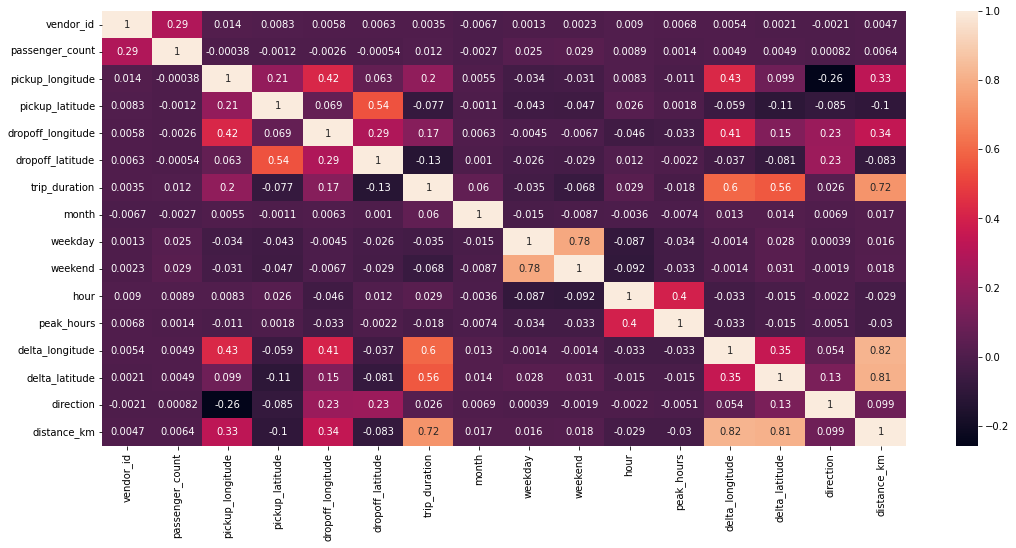

In [ ]:
# correlation
plt.figure(figsize = (18,8))
corr = df.corr()
corr
sns.heatmap(corr, annot = True)

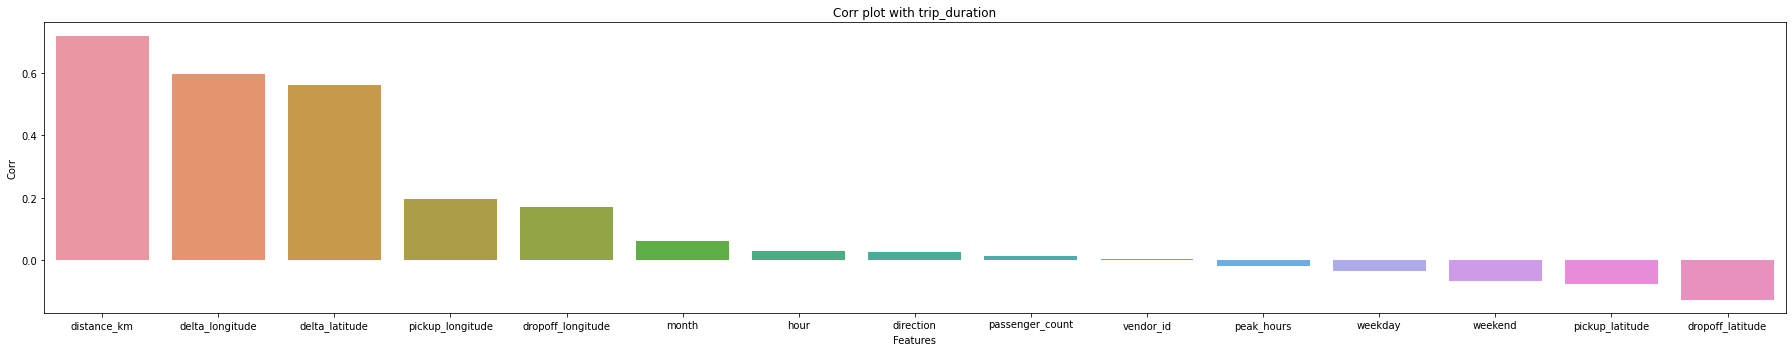

In [ ]:
l = df.loc[:, df.columns != 'trip_duration'].corrwith(df['trip_duration'], axis = 0, method='pearson') 
l = l.sort_values(ascending=False)
plt.figure(figsize = (25,5))
ax = sns.barplot(x=l.index, y=l)
ax.set(xlabel='Features', ylabel='Corr')  
plt.title('Corr plot with trip_duration')
plt.tight_layout()
plt.show()

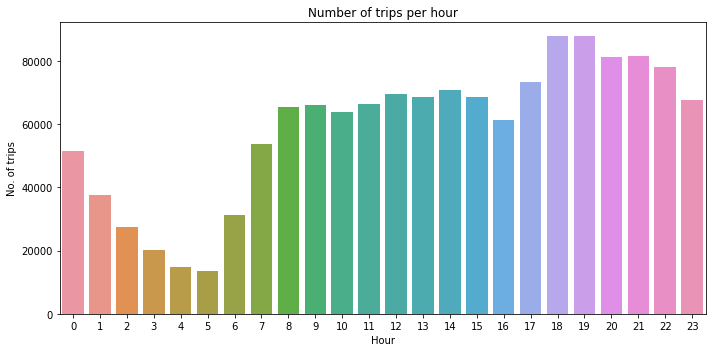

4815

In [ ]:
# Plot histogram of trip duration per hour
plt.figure(figsize = (10,5))
new_df = df.groupby('hour', as_index = False)['trip_duration'].agg(['count']).sort_values(by = 'hour', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='Hour', ylabel='No. of trips')  
plt.title('Number of trips per hour')
plt.tight_layout()
plt.show()
del new_df
gc.collect()

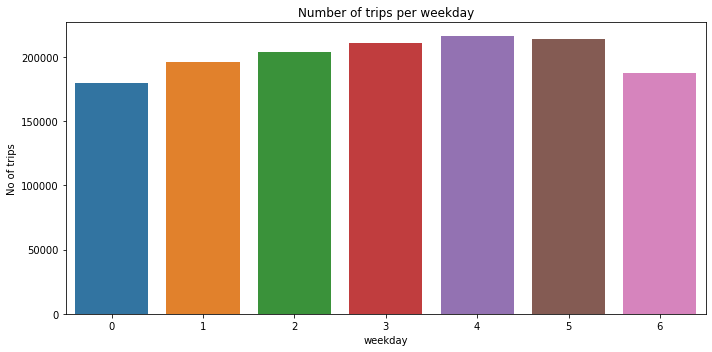

6527

In [ ]:
# Plot histogram of trips per weekday
plt.figure(figsize = (10,5))
new_df = df.groupby('weekday', as_index = False)['trip_duration'].agg(['count']).sort_values(by = 'weekday', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['count'])
ax.set(xlabel='weekday', ylabel='No of trips')  
plt.title('Number of trips per weekday')
plt.tight_layout()
plt.show()
del new_df
gc.collect()

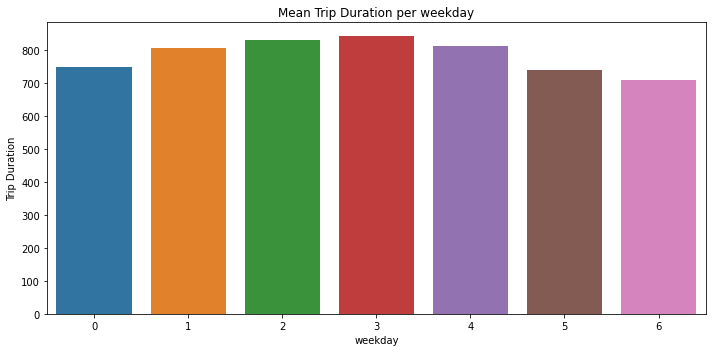

3127

In [ ]:
# Plot histogram of mean trip_duration per weekday
plt.figure(figsize = (10,5))
new_df = df.groupby('weekday', as_index = False)['trip_duration'].agg(['mean']).sort_values(by = 'weekday', ascending = True)
ax = sns.barplot(x=new_df.index, y=new_df['mean'])
ax.set(xlabel='weekday', ylabel='Trip Duration')  
plt.title('Mean Trip Duration per weekday')
plt.tight_layout()
plt.show()
del new_df
gc.collect()

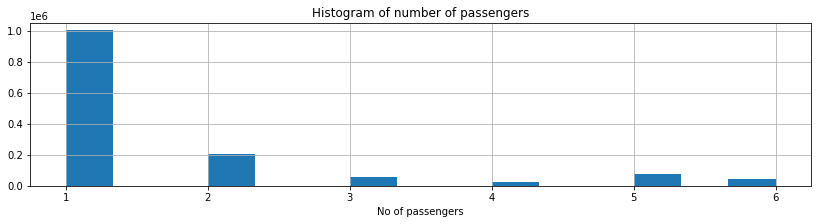

In [ ]:
# Plot histogram of passengers
df.passenger_count.hist(bins=15, figsize=(14,3))
plt.xlabel('No of passengers')
plt.title('Histogram of number of passengers');

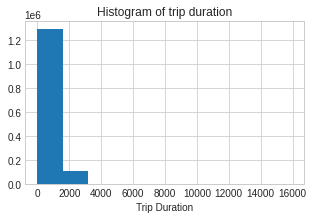

In [ ]:
# matplotlib inline
plt.style.use('seaborn-whitegrid')

# Plot histogram of fare
df.trip_duration.hist(bins=10, figsize=(5,3))
plt.xlabel('Trip Duration')
plt.title('Histogram of trip duration');

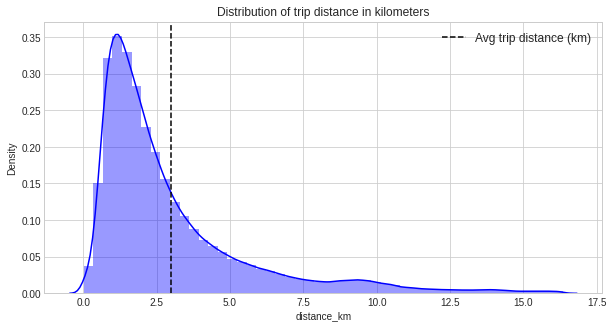

In [ ]:
plt.figure(figsize = (10,5))
sns.distplot(df["distance_km"],color = "b")
plt.axvline(df["distance_km"].mean(),color = "k",
            linestyle = "dashed",label = "Avg trip distance (km)")
plt.title("Distribution of trip distance in kilometers")
plt.legend(loc = "best",prop = {"size" : 12})
plt.show()

In [ ]:
# Converting categorical variable into dummy/indicator variables
df = pd.get_dummies(df, columns=['vendor_id', 'weekday', 'store_and_fwd_flag', 'month', 'weekday', 'weekend', 'hour', 'peak_hours'], drop_first = True)

In [ ]:
# removing unnecessary columns
df = df.drop(['id','pickup_datetime', 'dropoff_datetime','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude'], axis=1)


In [ ]:
# Input Feature Scaling
X = df.loc[:, df.columns != "trip_duration"].apply(zscore)
y = df['trip_duration']

In [ ]:
X.head()

,passenger_count,delta_longitude,delta_latitude,direction,distance_km,vendor_id_2,weekday_1,weekday_2,weekday_3,weekday_4,...,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23,peak_hours_1
0,-0.504309,-0.093147,-0.897100,-0.280860,-0.545732,0.935045,-0.402278,-0.410939,-0.419908,-0.425569,...,-0.226181,-0.213089,4.262264,-0.25785,-0.257768,-0.247583,-0.247822,-0.242068,-0.224391,-0.472332
1,-0.504309,-0.031330,-0.626611,-0.364681,-0.430849,-1.069467,-0.402278,-0.410939,-0.419908,-0.425569,...,-0.226181,-0.213089,-0.234617,-0.25785,-0.257768,-0.247583,-0.247822,-0.242068,-0.224391,-0.472332
2,-0.504309,0.259083,1.847421,-0.347322,1.266458,0.935045,2.485846,-0.410939,-0.419908,-0.425569,...,-0.226181,-0.213089,-0.234617,-0.25785,-0.257768,-0.247583,-0.247822,-0.242068,-0.224391,-0.472332
3,-0.504309,-0.706718,-0.315477,-0.344656,-0.549438,0.935045,-0.402278,2.433454,-0.419908,-0.425569,...,-0.226181,-0.213089,-0.234617,-0.25785,3.879453,-0.247583,-0.247822,-0.242068,-0.224391,2.117156
4,-0.504309,-0.790874,-0.452042,-0.343158,-0.660615,0.935045,-0.402278,-0.410939,-0.419908,-0.425569,...,-0.226181,-0.213089,-0.234617,-0.25785,-0.257768,-0.247583,-0.247822,-0.242068,-0.224391,-0.472332


In [ ]:
# train test split
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split( X,y , test_size = 0.3, random_state = 0) 
print(X_train.shape)
print(X_test.shape)

(986083, 49)
(422607, 49)


# Modeling 

In [ ]:
# defining a function to get all evaluations metrics
def evaluation_metrics(y_test, y_pred):
  
  r2 = round(r2_score(y_test, y_pred), 2)
  print("R2 on test data:" ,r2)

  MSE  = round(mean_squared_error(y_test, y_pred), 2)
  print("MSE :" , MSE)

  RMSE = round(np.sqrt(MSE), 2)
  print("RMSE :" ,RMSE)

  MAE = round(mean_absolute_error(y_test, y_pred), 2)
  print("MAE :" ,MAE)

## baseline model

In [ ]:
y_pred = y_test.mean()
baseline_errors = abs(y_pred - y_test)
print('Average baseline error (MAE): ', round(np.mean(baseline_errors), 2))

Average baseline error (MAE):  413.33


## Linear Regression

In [ ]:
reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)

In [ ]:
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.57
MSE : 133915.42
RMSE : 365.94
MAE : 248.37


## Lasso regression

In [ ]:
### Cross validation
lasso = Lasso()
parameters = {'alpha': [1e-3,1e-2,1e-1,1,5,10,20]}
lasso_regressor = GridSearchCV(lasso, parameters, scoring='neg_mean_squared_error', cv=5)
lasso_regressor.fit(X_train, y_train)
y_pred = lasso_regressor.predict(X_test)

In [ ]:
print("The best fit alpha value is found out to be :" ,lasso_regressor.best_params_)
print("\nUsing ",lasso_regressor.best_params_, " the negative mean squared error is: ", lasso_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 0.001}

Using  {'alpha': 0.001}  the negative mean squared error is:  -133089.6643092965


In [ ]:
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.57
MSE : 133914.8
RMSE : 365.94
MAE : 248.38


## Ridge regression

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge()
parameters = {'alpha': [1e-3,1e-2,1,5,10,20]}
ridge_regressor = GridSearchCV(ridge, parameters, scoring='neg_mean_squared_error', cv=3)
ridge_regressor.fit(X_train,y_train)
y_pred = ridge_regressor.predict(X_test)

In [ ]:
print("The best fit alpha value is found out to be :" ,ridge_regressor.best_params_)
print("\nUsing ",ridge_regressor.best_params_, " the negative mean squared error is: ", ridge_regressor.best_score_)

The best fit alpha value is found out to be : {'alpha': 1}

Using  {'alpha': 1}  the negative mean squared error is:  -133092.71279659992


In [ ]:
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.57
MSE : 133914.77
RMSE : 365.94
MAE : 248.38


## Decision Tree Regressor 

In [ ]:
param_grid = {"min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8],
              "min_samples_leaf": [20, 40],
              "max_leaf_nodes": [5, 20],
              }

dtm = DecisionTreeRegressor()
grid_cv_dtm = GridSearchCV(dtm, param_grid, cv=5)
grid_cv_dtm.fit(X,y)
y_pred = grid_cv_dtm.predict(X_test)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 6, 8], 'max_leaf_nodes': [5, 20],
                         'min_samples_leaf': [20, 40],
                         'min_samples_split': [10, 20, 40]})

In [ ]:
grid_cv_dtm.best_params_

{'max_depth': 8,
 'max_leaf_nodes': 20,
 'min_samples_leaf': 20,
 'min_samples_split': 10}

In [ ]:
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.56
MSE : 138504.49
RMSE : 372.16
MAE : 250.61


## Random Forest Regressor

In [ ]:
# Create the parameter grid based on the results of random search
from sklearn.ensemble import RandomForestRegressor 
param_grid = {'n_estimators': [10, 25], 'max_features': [5, 10], 
 'max_depth': [10, 50, None], 'bootstrap': [True, False]}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search_rf.fit(X_train,y_train)
y_pred = grid_search_rf.predict(X_test)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


In [ ]:
grid_search_rf.best_params_

{'bootstrap': True, 'max_depth': 50, 'max_features': 10, 'n_estimators': 25}

In [ ]:
evaluation_metrics(y_test, y_pred)

R2 on test data: 0.66
MSE : 107773.48
RMSE : 328.29
MAE : 213.14


In [ ]:
important = grid_search_rf.feature_importances_

important_dict = {'Feature' : list(X_train.columns),
                   'Feature Importance' : important}

important_df = pd.DataFrame(important_dict)
important_df['Feature Importance'] = round(important_df['Feature Importance'],2)

In [ ]:
important_df.sort_values(by=['Feature Importance'],ascending=False,inplace=True)
important_df

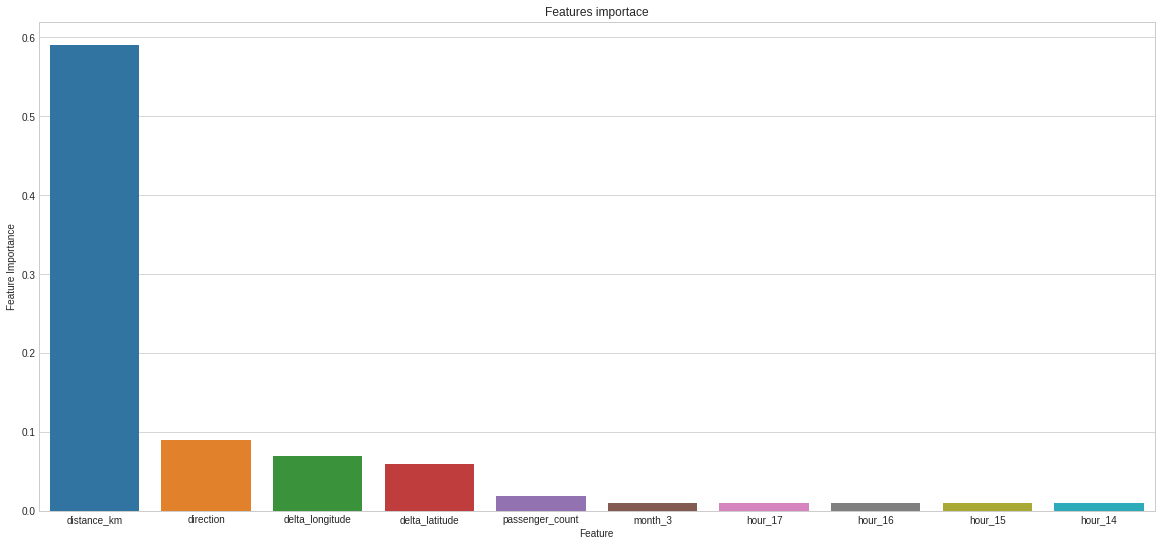

In [ ]:
plt.figure(figsize=(20,9))
plt.title('Features importace')
sns.barplot(x='Feature',y="Feature Importance",data=important_df[:10])

# Conclusions


*   Linear, Lasso and Ridge regressions are giving the similar results. And They are performing better than the baseline model.
*   In Decision Tree regressor, the results are slightly poor than that of linear models.
*   Out of all tried models, Random Forest is giving the best result.

